# Imports

In [ ]:
import pickle as pkl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers, regularizers, optimizers
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator

# Load Training Data

In [ ]:
with open("images_l.pkl", "rb") as f:
    images = pkl.load(f)

with open("labels_l.pkl", "rb") as f1:
    labels = pkl.load(f1)

with open("images_ul.pkl", "rb") as f2:
    ul_images = pkl.load(f2)

# Transform Labels

In [ ]:
# Transform the labels into combinations of number and character (e.g. "1a")
mlb = LabelBinarizer()
labels = [f'{str(i[:10].argmax())}{chr(i[10:].argmax() + 97)}' for i in labels]
labels = mlb.fit_transform(labels)

# Auxilary Functions

In [ ]:
def denoise(image,sigmanum):
    return ndimage.gaussian_filter(image, sigma = sigmanum)

In [ ]:
def threshold(image,num):
    return np.where(image > num,255,0)

In [ ]:
def rotation(image,degree):
    return ndimage.rotate(image, degree, reshape=False)

In [ ]:
# Segmentation was meant to separate the number and the character from each image,
# but we ultimately abandoned this method due to the inability of finding an
# effective clustering method
def segmentation(img): 
    de_img = denoise(img,0.5)
    toreturn = []
    mem = [] #medium to store all the properties of the object
    ret,thresh1 = cv2.threshold(de_img,100,255,cv2.THRESH_BINARY)
    thresh1 = thresh1.astype(np.uint8)
    contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        flag = False
        x,y,w,h = cv2.boundingRect(cnt)
        #bound the images
        #too small(noise)
        if w>4 or h>4 : #was 8 and 8 
            #save individual images
            for m in mem:
                px,py,pw,ph = m
                #if ((abs(px-x) + abs(py-y)) or (abs(px+pw-x) + abs(py+ph-y)) or (abs(px+pw-x-w) + abs(py+ph-y-h)) \
                                               #or (abs(px-x-w) + abs(py-y-h))< 5):
                #if((abs(px-x) + abs(py-y)) < 8):
                    #flag = True
                pxs = set(range(px,px+pw))
                l1 = len(pxs.intersection(range(x,x+w)))
                pxy = set(range(py,py+ph))
                l2 = len(pxy.intersection(range(y,y+h)))
                if (l1 > 2 and l2 > 2):
                    flag = True
                    break
            if (flag == True):
                continue
            mem.append([x,y,w,h])
            max1 = max(w,h)
            w = max1
            h = max1
            cropped_image = img[y:(y+h),x:(x+w)]
            resized = cv2.resize(cropped_image,(56,56), interpolation = cv2.INTER_AREA) 
            toreturn.append(resized)
    if(len(toreturn) == 1):
        x,y,w,h = mem[0]
        if(w > h):
            new_w = w//2 
            cropped_image = img[y:(y+h),x:(x+new_w)]
            cropped_image2 = img[y:(y+h),x+new_w:(x+w)]
            resized = cv2.resize(cropped_image,(56,56), interpolation = cv2.INTER_AREA) 
            resized2 = cv2.resize(cropped_image2,(56,56), interpolation = cv2.INTER_AREA) 
            toreturn = []
            toreturn.append(resized)
            toreturn.append(resized2)
        else:
            new_h = h//2
            cropped_image = img[y:(y+new_h),x:(x+w)]
            cropped_image2 = img[y+new_h:(y+h),x:(x+w)]
            resized = cv2.resize(cropped_image,(56,56), interpolation = cv2.INTER_AREA) 
            resized2 = cv2.resize(cropped_image2,(56,56), interpolation = cv2.INTER_AREA) 
            toreturn = []
            toreturn.append(resized)
            toreturn.append(resized2)
    if(len(toreturn) > 2):
        newlist = []
        toreturn = []
        for i in mem:
            x,y,w,h = i
            area = w*h
            newlist.append([x,y,w,h,area])
        npnew = np.array(newlist)
        sortedArr = npnew[npnew[:,-1].argsort()]
        #print(sortedArr)
        sortedArr = sortedArr[-2:,:4]
        #print(sortedArr)
        for j in sortedArr:
            x,y,w,h = j
            max1 = max(w,h)
            w = max1
            h = max1
            cropped_image = img[y:(y+h),x:(x+w)]
            resized = cv2.resize(cropped_image,(56,56), interpolation = cv2.INTER_AREA) 
            toreturn.append(resized)
    #else if(len(toreturn) == 1)
    return toreturn
        

# Network Architecture

Small VGGNet Architecture Taken from https://www.kaggle.com/mobasshir/keras-small-vgg-network

In [ ]:
def net():
    model = Sequential([
        Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(56, 56, 1)),
        BatchNormalization(),
        MaxPool2D(pool_size=(3, 3)),
        Dropout(0.25),
        Conv2D(64, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
		Dense(1024),
		Activation("relu"),
		BatchNormalization(),
		Dropout(0.5),
        Dense(260, activation="softmax"),   # Transformations applied above require           
    ])                                      # the output size to change from 36 to 260
    opt = tf.keras.optimizers.Adam()# learning_rate=0.0005, decay=0.005 / 75)
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=opt, metrics=['accuracy'])
    return model

# Declare a Model Instance

In [ ]:
model = net()
# model.summary()

# Normalize & Denoise the Training Images

In [ ]:
images = images / 255.0
images = np.apply_along_axis(lambda i: denoise(i, 0.69), 1, images)

images = images.reshape(30000, 56, 56, 1)
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, train_size=0.8, 
                                                                      random_state=551, shuffle=True)
print(train_images.shape)
print(train_labels.shape)

(24000, 56, 56, 1)
(24000, 260)


In [ ]:
ul_images = ul_images / 255.0
ul_images = np.apply_along_axis(lambda i: denoise(i, 0.69), 1, ul_images)
ul_images = ul_images.reshape(30000, 56, 56, 1)

# Train & Employ the Model

We choose the best performing setup, which is batch size = 16 and epochs = 75, as our primary configuration. A few alternative configurations are also included below for reference.

## Train the Model with the Labelled Images

In [ ]:
datagen = ImageDataGenerator(rotation_range=10)
datagen.fit(train_images)
fit_16_75 = model.fit(datagen.flow(train_images, train_labels, batch_size=16), epochs=75,
                      batch_size=16, validation_data=(val_images, val_labels))

Epoch 1/75
1500/1500 [==============================] - 22s 11ms/step - loss: 0.0703 - accuracy: 0.0136 - val_loss: 0.0233 - val_accuracy: 0.0182
Epoch 2/75
1500/1500 [==============================] - 16s 11ms/step - loss: 0.0224 - accuracy: 0.0384 - val_loss: 0.0218 - val_accuracy: 0.0588
Epoch 3/75
1500/1500 [==============================] - 17s 11ms/step - loss: 0.0202 - accuracy: 0.0723 - val_loss: 0.0222 - val_accuracy: 0.0740
Epoch 4/75
1500/1500 [==============================] - 17s 11ms/step - loss: 0.0177 - accuracy: 0.1287 - val_loss: 0.0150 - val_accuracy: 0.2198
Epoch 5/75
1500/1500 [==============================] - 16s 11ms/step - loss: 0.0152 - accuracy: 0.2356 - val_loss: 0.0148 - val_accuracy: 0.2558
Epoch 6/75
1500/1500 [==============================] - 17s 11ms/step - loss: 0.0124 - accuracy: 0.3820 - val_loss: 0.0136 - val_accuracy: 0.4043
Epoch 7/75
1500/1500 [==============================] - 17s 11ms/step - loss: 0.0101 - accuracy: 0.5330 - val_loss: 0.0145 -

## Loss & Accuracy VS. Epoch Plots

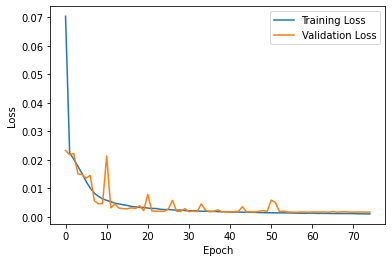

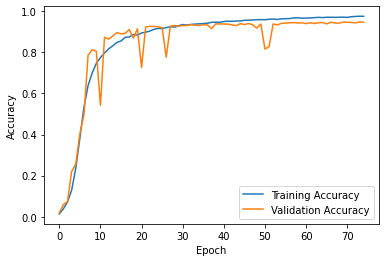

In [ ]:
x_axis = np.arange(75)
plt.plot(x_axis, fit_16_75.history["loss"], label = "Training Loss")
plt.plot(x_axis, fit_16_75.history["val_loss"], label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(x_axis, fit_16_75.history["accuracy"], label = "Training Accuracy")
plt.plot(x_axis, fit_16_75.history["val_accuracy"], label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Make Use of the Unlabelled Images

Draw predictions on the unlabelled images and use the prediction to supplement the training set.

In [ ]:
ul_pred = model.predict(ul_images)
model = net()
new_train = np.append(images, ul_images, axis=0)
new_label = np.append(labels, ul_pred,axis=0)
ti, vi, tl, vl = train_test_split(new_train, new_label, train_size=0.8, 
                 random_state=551, shuffle=True)

datagen = ImageDataGenerator(rotation_range=10)
datagen.fit(ti)
fit_with_ul = model.fit(datagen.flow(ti, tl, batch_size=16), epochs=75,
                        batch_size=16, validation_data=(vi, vl))


Epoch 1/75
3000/3000 [==============================] - 34s 11ms/step - loss: 0.0463 - accuracy: 0.0196 - val_loss: 0.0275 - val_accuracy: 0.0184
Epoch 2/75
3000/3000 [==============================] - 32s 11ms/step - loss: 0.0206 - accuracy: 0.0663 - val_loss: 0.0170 - val_accuracy: 0.1218
Epoch 3/75
3000/3000 [==============================] - 34s 11ms/step - loss: 0.0154 - accuracy: 0.2183 - val_loss: 0.0109 - val_accuracy: 0.4377
Epoch 4/75
3000/3000 [==============================] - 32s 11ms/step - loss: 0.0102 - accuracy: 0.5144 - val_loss: 0.0090 - val_accuracy: 0.6274
Epoch 5/75
3000/3000 [==============================] - 35s 12ms/step - loss: 0.0071 - accuracy: 0.6998 - val_loss: 0.0035 - val_accuracy: 0.8716
Epoch 6/75
3000/3000 [==============================] - 33s 11ms/step - loss: 0.0056 - accuracy: 0.7789 - val_loss: 0.0043 - val_accuracy: 0.8267
Epoch 7/75
3000/3000 [==============================] - 33s 11ms/step - loss: 0.0048 - accuracy: 0.8152 - val_loss: 0.0086 -

# Alternative Configurations 

Do not run both the configurations in this section and the primary configuration above, otherwise the models will overwrite each other.

## Batch Size = 16, Epochs = 50

In [ ]:
model = net()
fit_16_50 = model.fit(train_images, train_labels, batch_size=16, epochs=50,
                      validation_data=(val_images, val_labels))

Epoch 1/50
1500/1500 [==============================] - 10s 6ms/step - loss: 0.1135 - accuracy: 0.0117 - val_loss: 0.0286 - val_accuracy: 0.0150
Epoch 2/50
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0227 - accuracy: 0.0272 - val_loss: 0.0345 - val_accuracy: 0.0183
Epoch 3/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0212 - accuracy: 0.0382 - val_loss: 0.0221 - val_accuracy: 0.0322
Epoch 4/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0201 - accuracy: 0.0547 - val_loss: 0.0203 - val_accuracy: 0.0493
Epoch 5/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0190 - accuracy: 0.0763 - val_loss: 0.0194 - val_accuracy: 0.0618
Epoch 6/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0174 - accuracy: 0.1216 - val_loss: 0.0152 - val_accuracy: 0.1737
Epoch 7/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0158 - accuracy: 0.1944 - val_loss: 0.0135 - val_accuracy

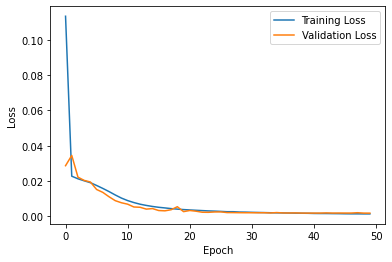

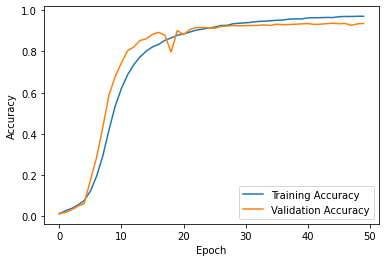

In [ ]:
x_axis = np.arange(50)
plt.plot(x_axis, fit_16_50.history["loss"], label = "Training Loss")
plt.plot(x_axis, fit_16_50.history["val_loss"], label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(x_axis, fit_16_50.history["accuracy"], label = "Training Accuracy")
plt.plot(x_axis, fit_16_50.history["val_accuracy"], label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Batch Size = 32, Epochs = 50

Epoch 1/50
750/750 [==============================] - 7s 8ms/step - loss: 0.1919 - accuracy: 0.0063 - val_loss: 0.0267 - val_accuracy: 0.0102
Epoch 2/50
750/750 [==============================] - 5s 7ms/step - loss: 0.0250 - accuracy: 0.0185 - val_loss: 0.0333 - val_accuracy: 0.0158
Epoch 3/50
750/750 [==============================] - 5s 7ms/step - loss: 0.0228 - accuracy: 0.0287 - val_loss: 0.0235 - val_accuracy: 0.0158
Epoch 4/50
750/750 [==============================] - 5s 7ms/step - loss: 0.0215 - accuracy: 0.0341 - val_loss: 0.0237 - val_accuracy: 0.0165
Epoch 5/50
750/750 [==============================] - 5s 7ms/step - loss: 0.0205 - accuracy: 0.0497 - val_loss: 0.0201 - val_accuracy: 0.0452
Epoch 6/50
750/750 [==============================] - 6s 7ms/step - loss: 0.0195 - accuracy: 0.0692 - val_loss: 0.0187 - val_accuracy: 0.0670
Epoch 7/50
750/750 [==============================] - 6s 7ms/step - loss: 0.0186 - accuracy: 0.0906 - val_loss: 0.0193 - val_accuracy: 0.0743
Epoch 

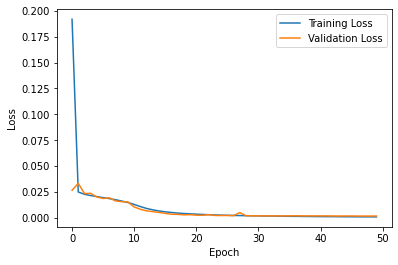

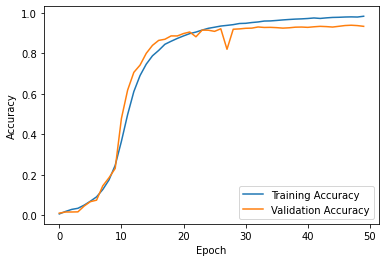

In [ ]:
model = net()
fit_32_50 = model.fit(train_images, train_labels, batch_size=32, epochs=50,
                      validation_data=(val_images, val_labels))
x_axis = np.arange(50)
plt.plot(x_axis, fit_32_50.history["loss"], label = "Training Loss")
plt.plot(x_axis, fit_32_50.history["val_loss"], label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(x_axis, fit_32_50.history["accuracy"], label = "Training Accuracy")
plt.plot(x_axis, fit_32_50.history["val_accuracy"], label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Batch Size = 8, Epochs = 50

Epoch 1/50
3000/3000 [==============================] - 31s 5ms/step - loss: 0.0736 - accuracy: 0.0135 - val_loss: 0.0266 - val_accuracy: 0.0183
Epoch 2/50
3000/3000 [==============================] - 15s 5ms/step - loss: 0.0230 - accuracy: 0.0272 - val_loss: 0.0223 - val_accuracy: 0.0270
Epoch 3/50
3000/3000 [==============================] - 15s 5ms/step - loss: 0.0212 - accuracy: 0.0503 - val_loss: 0.0209 - val_accuracy: 0.0557
Epoch 4/50
3000/3000 [==============================] - 15s 5ms/step - loss: 0.0195 - accuracy: 0.0742 - val_loss: 0.0188 - val_accuracy: 0.0972
Epoch 5/50
3000/3000 [==============================] - 15s 5ms/step - loss: 0.0181 - accuracy: 0.1105 - val_loss: 0.0165 - val_accuracy: 0.1485
Epoch 6/50
3000/3000 [==============================] - 15s 5ms/step - loss: 0.0166 - accuracy: 0.1637 - val_loss: 0.0143 - val_accuracy: 0.2500
Epoch 7/50
3000/3000 [==============================] - 16s 5ms/step - loss: 0.0153 - accuracy: 0.2234 - val_loss: 0.0128 - val_ac

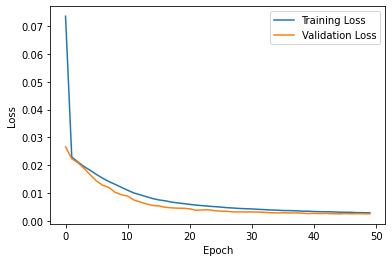

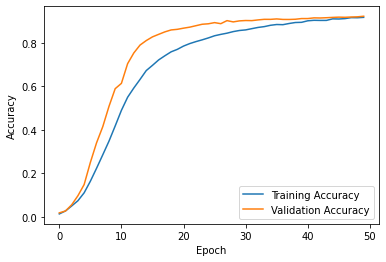

In [ ]:
model = net()
fit_8_50 = model.fit(train_images, train_labels, batch_size=8, epochs=50,
                     validation_data=(val_images, val_labels))
x_axis = np.arange(50)
plt.plot(x_axis, fit_8_50.history["loss"], label = "Training Loss")
plt.plot(x_axis, fit_8_50.history["val_loss"], label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(x_axis, fit_8_50.history["accuracy"], label = "Training Accuracy")
plt.plot(x_axis, fit_8_50.history["val_accuracy"], label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Backup the Trained Model

In [ ]:
# Save our trained model
model.save('Backup')

INFO:tensorflow:Assets written to: Backup/assets


# Produce Predictions on the Test Set

## Load & preprocess the test data.

In [ ]:
with open("images_test.pkl", "rb") as f:
    tests = pkl.load(f)

# Normalize & denoise the test images
tests = tests / 255.0
tests = np.apply_along_axis(lambda i: denoise(i, 0.69), 1, tests)
tests = tests.reshape(15000, 56, 56, 1)

## Draw Predictions

Feed the test data into the trained model to get predictions of length 260.

In [ ]:
pred = model.predict(tests)
print(pred.shape)

(15000, 260)


Map the predictions back into the required format of length 36.

In [ ]:
import pandas as pd

prediction = []
for data in pred:
    ''' Prediction scheme without label merging (i.e. output length=36 instead of 260)
    num = data[:10].argmax()
    char = data[10:].argmax()
    prediction.append(''.join(['0' if i != num and i != char + 10 else '1' for i in range(36)]))'''
    result = data.argmax()
    num = result // 26
    char = result % 26
    prediction.append(''.join(['0' if i != num and i != char + 10 else '1' for i in range(36)]))


        

Write the predictions into an output file

In [ ]:
result = {"# Id": np.arange(15000), 'Category': prediction}
df = pd.DataFrame(data=result, columns=['# Id', 'Category'])
print(df.head())
df.to_csv('results.csv', header=True, index=False)

   # Id                              Category
0     0  100000000000000000000000000001000000
1     1  000010000000000000000100000000000000
2     2  000000000100000000010000000000000000
3     3  100000000000000000000100000000000000
4     4  000000100000000000010000000000000000
